**Definicion de las funciones de los potenciales y de los calculos de angulos que seran utilizados en las demas secciones de desviacion**

In [ ]:
import numpy as np
from scipy.integrate import quad
from scipy import constants
import matplotlib.pyplot as plt
from scipy.optimize import brentq, newton, fsolve

# Definir los parámetros conocidos
q1 = constants.e * 79  # Masa que esta en el foco (Nucleo de oro)
q2 = constants.e * 2   # Particula Alpha
m = 6.64424e-27       # Masa de la particula alpha
k = (q1*q2)/(4*np.pi*constants.epsilon_0)  # Constante del potencial


# Se definen los integrandos para cada potencial que luego seran integrados numericamente para encontrar el angulo de scatter

def Yunkawa(u,alpha):
    return (k*u) * np.exp(-alpha * (1/u))

def Coulomb(u):
    return (k*u)

def integrandY(u,E,b,alpha):
    return 1 / np.sqrt(1 - Yunkawa(u,alpha) / E - b ** 2 * u ** 2)

def integrandC(u,E,b):
    return 1 / np.sqrt(1 - Coulomb(u) / E - b ** 2 * u ** 2)


#Se define las raices de la ecuacion para el potencial de coulomb la cual utilizaremos como punto de aproximacion para hacer el newton sobre
#la ecuacion con el potencial de Yukawa. Esta ecuacion de la que hablamos es la ecuacion para determinar los rmin y poder realizar la integracion numerica

def coulomb_analytic(E, b):
    l2 = 2 * E * m * b ** 2  # Momento angular al cuadrado

    # Coeficientes de la ecuación
    coef = [E,-k, -l2 / (2 * m)]

    # Usamos np.roots para encontrar las raíces de la ecuación
    roots = np.roots(coef)

    # Filtrar las raíces reales positivas
    roots_reales = [r.real for r in roots if r.imag == 0 and r.real > 0]

    if roots_reales:
        r_min = min(roots_reales)  # Nos interesa la raíz más pequeña
        return r_min
    else:
        raise ValueError("No se encontraron raíces reales y positivas.")

#Funcion que calcula el umin para el potencial de Yukawa


def umin(E, b, alpha):
    l2 = 2 * E * m * b ** 2  # Momento angular al cuadrado

    def ecuacion(r):
        return  E * r ** 2 - k*r*np.exp(-alpha*r) - l2 / (2 * m)
    posible=coulomb_analytic(E,b)
    # Encontrar el valor de r que minimiza la distancia
    raiz = newton(ecuacion,posible)
    return 1 / raiz  # Devuelve el valor en términos de u_min


#Se realiza el proceso de integracion numerico con los integrandos anteriores, y se definen los valores del momento angular, la e y la q para definir
#los limites de integracion en el potencial de Coulomb y para el de yukawa se utiliza la funcion anterior

def scatterY(E,b,alpha):
    u_m=umin(E,b,alpha)
    theta_max, error = quad(lambda u: integrandY(u, E, b,alpha), 0, u_m)
    x=np.pi-2 * theta_max * b
    return np.degrees(x)

def scatterC(E,b):
    l2 = 2 * E * m * b * b
    q = l2 / (m * k)
    e = np.sqrt(1 + ((2 * E * l2) / (m * k * k)))
    u_m = (e - 1) / q
    theta_max, error = quad(lambda u: integrandC(u, E, b), 0, u_m)
    x = np.pi - 2 * theta_max * b
    return np.degrees(x)



**Angulos de scattering para distintos parametros de b**

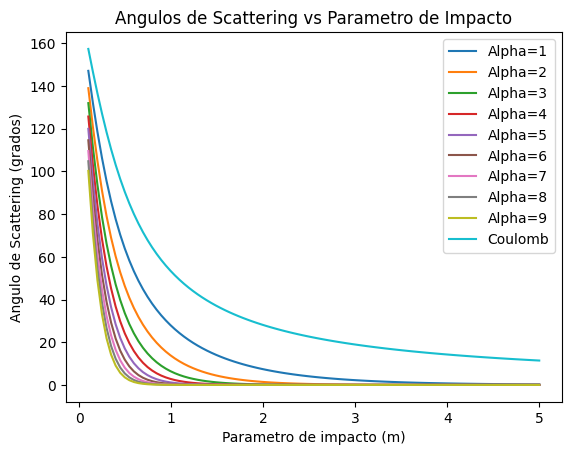

In [ ]:
E=1
k=1
m=1
b=np.linspace(0.1,5,100)
angulosY=[]
angulosC=[]
for i in range(9):
  angulosY=[]
  for j in range(len(b)):
    angulosY.append(scatterY(E,b[j],i+1))
  plt.plot(b,angulosY,label=f'Alpha={i+1}')
  plt.legend()

for j in range(len(b)):
  angulosC.append(scatterC(E,b[j]))

plt.plot(b,angulosC,label=f'Coulomb')
plt.legend()

plt.xlabel("Parametro de impacto (m)")
plt.ylabel("Angulo de Scattering (grados)")
plt.title("Angulos de Scattering vs Parametro de Impacto")
plt.legend()
plt.show()

**Angulos de scattering para distintas energias**

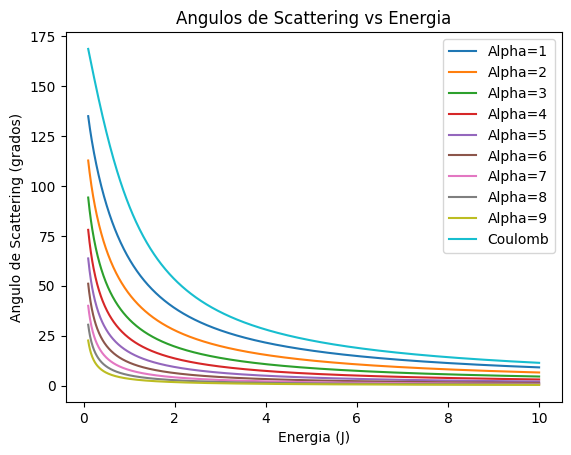

In [ ]:
b=0.5

E=np.linspace(0.1,10,1000)
angulosY=[]
angulosC=[]
for i in range(9):
  angulosY=[]
  for j in range(len(E)):
    angulosY.append(scatterY(E[j],b,i+1))

  plt.plot(E,angulosY,label=f'Alpha={i+1}')
  plt.legend()

for j in range(len(E)):
  angulosC.append(scatterC(E[j],b))

plt.plot(E,angulosC,label=f'Coulomb')
plt.legend()

plt.xlabel("Energia (J)")
plt.ylabel("Angulo de Scattering (grados)")
plt.title("Angulos de Scattering vs Energia")
plt.legend()
plt.show()



**Seccion transversal para diferentes alpha**


<ipython-input-108-7ed3c0fca3e7>:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e4)


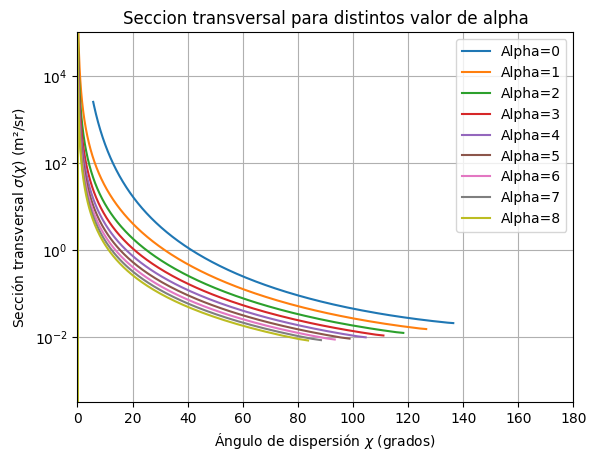

In [ ]:

m=1
k=1
E = 2  # Energía en julios (1 MeV)
b_vals = np.linspace(0.1, 5, 1000)  # Valores del parámetro de impacto

# Calcular el ángulo de dispersión chi para cada b

for i in range(9):
  chi_vals=[]
  for j in range(len(b_vals)):
    chi_vals.append(scatterY(E,b_vals[j],i))
  chi_vals = np.radians(chi_vals)
  # Cálculo numérico de db/dchi usando diferencias finitas
  db_dchi = np.gradient(b_vals, chi_vals)
  sigma_numerical = (b_vals / np.sin(chi_vals)) * np.abs(db_dchi)
  plt.plot(np.degrees(chi_vals), sigma_numerical, label=f'Alpha={i}')
  plt.legend()


plt.yscale('log')
plt.xlabel(r'Ángulo de dispersión $\chi$ (grados)')
plt.ylabel(r'Sección transversal $\sigma(\chi)$ (m²/sr)')
plt.title('Seccion transversal para distintos valor de alpha')
plt.ylim(0,10e4)
plt.xlim(0,180)
plt.legend()
plt.grid(True)
plt.show()

**Seccion transversal para diferentes energias**

<ipython-input-107-f2addb9480dd>:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e4)


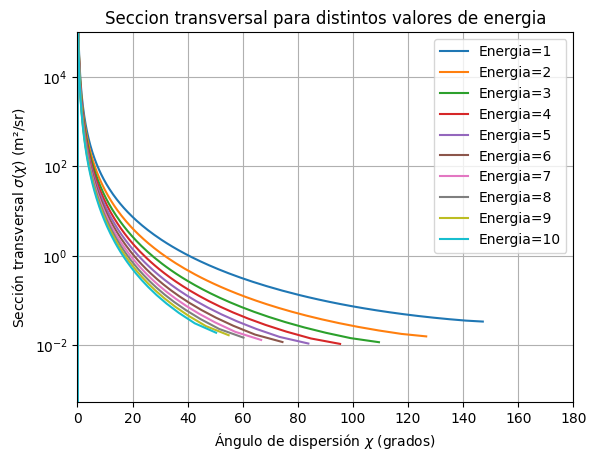

In [ ]:

m=1
k=1
alpha=1 # Energía en julios (1 MeV)
b_vals = np.linspace(0.1, 20, 1000)  # Valores del parámetro de impacto

# Calcular el ángulo de dispersión chi para cada b

for i in range(10):
  chi_vals=[]
  for j in range(len(b_vals)):
    chi_vals.append(scatterY(i+1,b_vals[j],alpha))
  chi_vals = np.radians(chi_vals)
  # Cálculo numérico de db/dchi usando diferencias finitas
  db_dchi = np.gradient(b_vals, chi_vals)
  sigma_numerical = (b_vals / np.sin(chi_vals)) * np.abs(db_dchi)
  plt.plot(np.degrees(chi_vals), sigma_numerical, label=f'Energia={i+1}')
  plt.legend()


plt.yscale('log')
plt.xlabel(r'Ángulo de dispersión $\chi$ (grados)')
plt.ylabel(r'Sección transversal $\sigma(\chi)$ (m²/sr)')
plt.title('Seccion transversal para distintos valores de energia')
plt.ylim(0,10e4)
plt.xlim(0,180)
plt.legend()
plt.grid(True)
plt.show()

**Graficas de los potenciales de Coulomb y de Yunkawa**

<ipython-input-110-1186b0203ad9>:15: RuntimeWarning: divide by zero encountered in divide
  return (k/r)*np.exp(-alpha*r)
<ipython-input-110-1186b0203ad9>:18: RuntimeWarning: divide by zero encountered in divide
  return (k/r)


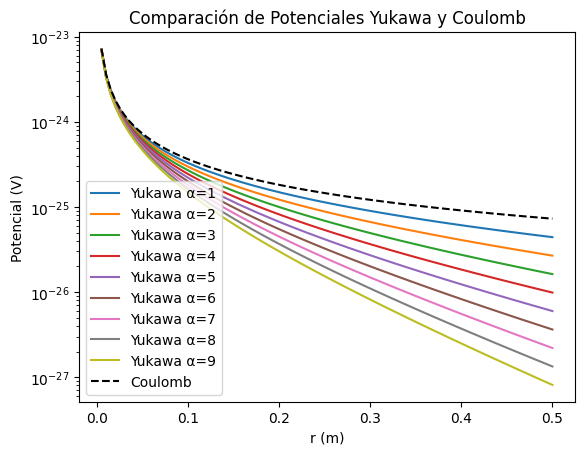

In [ ]:
import numpy as np
from scipy.integrate import quad
from scipy import constants
import matplotlib.pyplot as plt
from scipy.optimize import brentq


# Definir los parámetros conocidos
q1 = constants.e * 79  # Masa que esta en el foco (Nucleo de oro)
q2 = constants.e * 2   # Particula Alpha
m = 6.64424e-27       # Masa de la particula alpha
k = (q1*q2)/(4*np.pi*constants.epsilon_0)  # Constante del potencial

def YunkawaR(r,alpha):
  return (k/r)*np.exp(-alpha*r)

def CoulombR(r):
  return (k/r)

# Generar el array de r
r = np.linspace(0, 0.5, 100)

# Crear una lista de valores de alpha
alphas = range(1, 10)

# Colores y etiquetas
for i, alpha in enumerate(alphas):
    plt.plot(r, YunkawaR(r, alpha), label=f'Yukawa α={alpha}')

# Graficar el potencial de Coulomb
plt.plot(r, CoulombR(r), label='Coulomb', linestyle='--', color='black')

# Agregar leyenda, etiquetas y ajustar límites
plt.legend(loc='best')
plt.xlabel('r (m)')
plt.ylabel('Potencial (V)')
plt.title('Comparación de Potenciales Yukawa y Coulomb')

plt.yscale('log')
plt.show()